In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

Метрика: средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

Важная информация:
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

Описание данных:
id_product -  идентификатор продукта, который был рекомендован
is_pay - купил ли пользователь товар
sum_payment - размер платежа (0, если не купил)
city - город, в котором находится пользователь
id_user - пользователь
timestamp - timestamp события
date - дата события

Задачи, которые необходимо решить:
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.
Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.

Дополнительно:
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

In [2]:
df = pd.read_csv("ab_made_4.gzip", compression='gzip')
df['is_test'] = df['date'].apply(lambda x: x.split('-')[1][1]=='5')
df.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date,is_test
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01,False
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01,False
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01,False
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01,False
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01,False


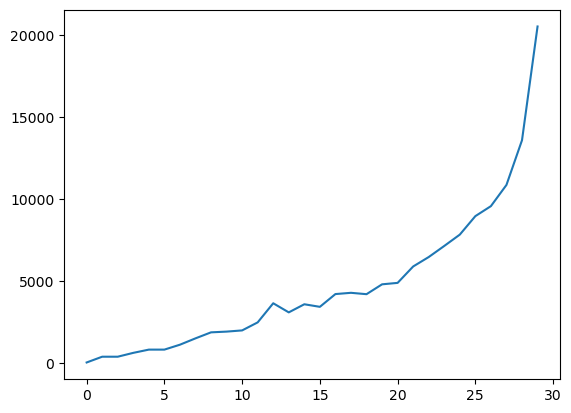

In [3]:
plt.plot(df[df['is_test']==False].groupby('date')['sum_payment'].sum().values)

Text(0.5, 1.0, 'average daily sum_payment')

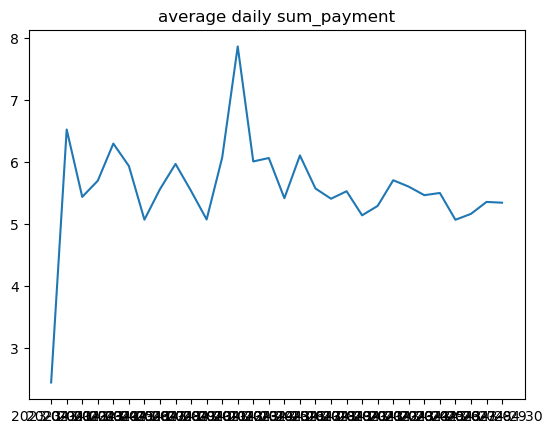

In [4]:
plt.plot(df[df['is_test']==False].groupby('date')['sum_payment'].sum()/df[df['is_test']==False].groupby('date')['id_user'].count())#.values
plt.title('average daily sum_payment')

In [34]:
df[df['date']=='2023-04-01']['sum_payment'].mean()
df = df[df['date']!='2023-04-01']

In [35]:
df_train =df[df['is_test']==False] 
df_test = df[df['is_test']==True][df['id_user'].isin(df_train['id_user'].values)]

C:\Users\death\AppData\Local\Temp\ipykernel_1776\616510032.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df[df['is_test']==True][df['id_user'].isin(df_train['id_user'].values)]


C:\Users\death\AppData\Local\Temp\ipykernel_1776\1239120027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['week'] = pd.to_datetime(df_train['date']).apply(lambda x: x.isocalendar()[1])


(array([9.121e+03, 7.100e+01, 2.089e+03, 5.550e+02, 5.240e+02, 8.190e+02,
        7.070e+02, 9.500e+01, 1.370e+02, 1.310e+02, 7.900e+01, 5.700e+01,
        5.100e+01, 3.000e+01, 1.900e+01, 1.000e+01, 1.100e+01, 5.000e+00,
        5.000e+00, 1.000e+00, 6.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00]),
 array([  0.  ,   5.48,  10.96,  16.44,  21.92,  27.4 ,  32.88,  38.36,
         43.84,  49.32,  54.8 ,  60.28,  65.76,  71.24,  76.72,  82.2 ,
         87.68,  93.16,  98.64, 104.12, 109.6 , 115.08, 120.56, 126.04,
        131.52, 137.  ]),
 <BarContainer object of 25 artists>)

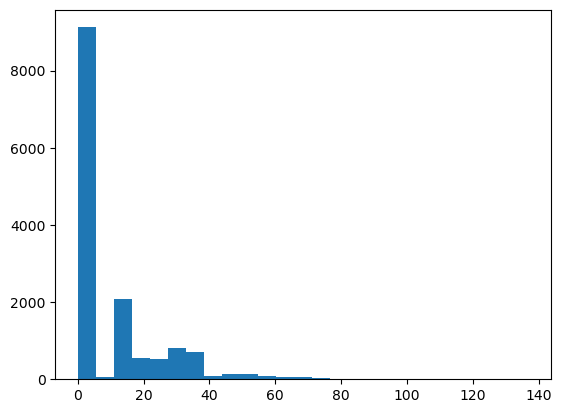

In [36]:
df_train['week'] = pd.to_datetime(df_train['date']).apply(lambda x: x.isocalendar()[1])
plt.hist(df_train.groupby(['week', 'id_user'])['sum_payment'].sum().values, bins=25)

In [37]:
len(df[df['is_test']==True]), len(df_test) # only old users

(30646, 25444)

(array([5.37e+03, 1.71e+03, 5.46e+02, 9.00e+02, 6.91e+02, 1.76e+02,
        2.24e+02, 1.22e+02, 7.40e+01, 4.70e+01, 2.90e+01, 1.80e+01,
        9.00e+00, 5.00e+00, 4.00e+00, 4.00e+00, 6.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00, 2.00e+00, 2.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00]),
 array([  0.  ,   8.12,  16.24,  24.36,  32.48,  40.6 ,  48.72,  56.84,
         64.96,  73.08,  81.2 ,  89.32,  97.44, 105.56, 113.68, 121.8 ,
        129.92, 138.04, 146.16, 154.28, 162.4 , 170.52, 178.64, 186.76,
        194.88, 203.  ]),
 <BarContainer object of 25 artists>)

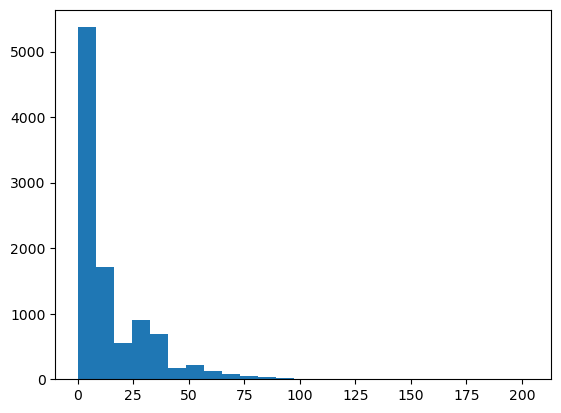

In [79]:
def metric(df, before=False):
    dates = df.groupby('id_user')['date'].min()
    dates_begin = pd.DataFrame(dates).reset_index()
    dates_begin.rename(columns={'date': 'start'}, inplace=True)
    dates_begin['start'] = pd.to_datetime(dates_begin['start'])
    dates_begin['end'] = dates_begin['start'].apply(lambda x: x + datetime.timedelta(days=7))
    if before:
        dates_begin = dates_begin[dates_begin['start'] < before]
    ddf = df.merge(dates_begin, left_on='id_user', right_on='id_user', how='left')
    return ddf[ddf['date'].between(ddf['start'], ddf['end'])].groupby('id_user')['sum_payment'].sum().reset_index()

m = metric(df_test)
plt.hist(m['sum_payment'].values, bins=25)

In [39]:
weeks_a = metric(df_train)['sum_payment'].values
weeks_b = m['sum_payment'].values

In [86]:
np.mean(weeks_b) - np.mean(weeks_a),  (np.mean(weeks_b) - np.mean(weeks_a))/ np.mean(weeks_a)# effect

(1.7955290317885453, 0.16057117177897454)

In [41]:
from scipy.stats import ttest_ind

In [72]:
ttest_ind(weeks_b, weeks_a, alternative='less') # не отвергаем гипотезу, что стало меньше

Ttest_indResult(statistic=6.693526337022939, pvalue=0.9999999999888167)

In [73]:
ttest_ind(weeks_b, weeks_a, alternative='greater') # отвергаем гипотезу, что стало лучше на всех данных

Ttest_indResult(statistic=6.693526337022939, pvalue=1.1183237642309179e-11)

In [80]:
p_values = []
for d in sorted(list(set(pd.to_datetime(df_test['date']).values))):
    weeks_b = metric(df_test, d)['sum_payment'].values
    p_values.append(ttest_ind(weeks_b, weeks_a, alternative='greater').pvalue)
#     p_values.append(ttest_ind(weeks_b, weeks_a, alternative='two-sided').pvalue)

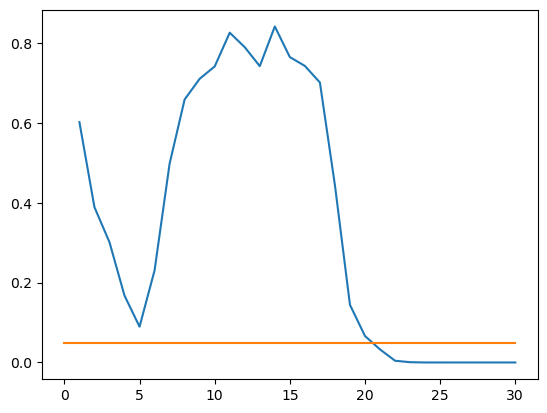

In [81]:
plt.plot(list(range(len(p_values))), p_values)
plt.plot([0, 30], [0.05, 0.05]) # no less 7 days

In [100]:
sum(df_train['is_pay'])/ len(df_train) # посмотреть на 600 человек

0.2577735580346546

In [101]:
# np.cumsum(df_test.groupby('date')['id_user'].count())#.values
dates = df_test.groupby('id_user')['date'].min()
dates_begin = pd.DataFrame(dates).reset_index()
dates_begin.rename(columns={'date': 'start'}, inplace=True)
# dates_begin['start'] = pd.to_datetime(dates_begin['start'])
# dates_begin['end'] = dates_begin['start'].apply(lambda x: x + datetime.timedelta(days=7))
ddf = df_test.merge(dates_begin, left_on='id_user', right_on='id_user', how='left')
ddf.groupby('start')['id_user'].count()

start
2023-05-01      39
2023-05-02     141
2023-05-03     243
2023-05-04     284
2023-05-05     434
2023-05-06     458
2023-05-07     461
2023-05-08     594
2023-05-09     566
2023-05-10     590
2023-05-11     695
2023-05-12     706
2023-05-13     739
2023-05-14     768
2023-05-15     789
2023-05-16     727
2023-05-17     860
2023-05-18     923
2023-05-19     944
2023-05-20     978
2023-05-21    1036
2023-05-22    1144
2023-05-23    1013
2023-05-24    1107
2023-05-25    1215
2023-05-26    1305
2023-05-27    1098
2023-05-28    1252
2023-05-29    1237
2023-05-30    1474
2023-05-31    1624
Name: id_user, dtype: int64

In [102]:
p_values[11]

0.8254933279088279